In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

In [2]:
# from Networks import *
import os
import shutil
import numpy as np
from collections import OrderedDict
import logging

In [3]:
from tf_unet import util
from tf_unet.layers import (weight_variable, weight_variable_devonc, bias_variable,
                            conv2d, deconv2d, max_pool, crop_and_concat, pixel_wise_softmax,
                            cross_entropy)
from tf_unet.image_gen import *
from tf_unet.unet import *

In [4]:
from Utility import *
import Logger

In [5]:
from matplotlib import pyplot as plt

In [6]:
# dataFolder = r'Z:\2021_03_01_RandomlyDeformedGridMesh\Data128'
# outputFolder = r'Z:\2021_03_01_RandomlyDeformedGridMesh\Training128'

dataFolder = r'F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Data128'
outputFolder = r'F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128'

numMarkers = 50
markerSelected =[47]

numTest = 200

In [7]:
imgsPerMaker = []
uvsPerMaker = []

for iM in markerSelected:
    outImgDataFile = join(dataFolder, 'ImgMarker_' + str(iM).zfill(3) + '.npy')
    outUVDataFile = join(dataFolder, 'UVMarker_' + str(iM).zfill(3) + '.npy')

    img = np.load(outImgDataFile)
    uv = np.load(outUVDataFile)
    
    imgsPerMaker.append(img)
    uvsPerMaker.append(uv)

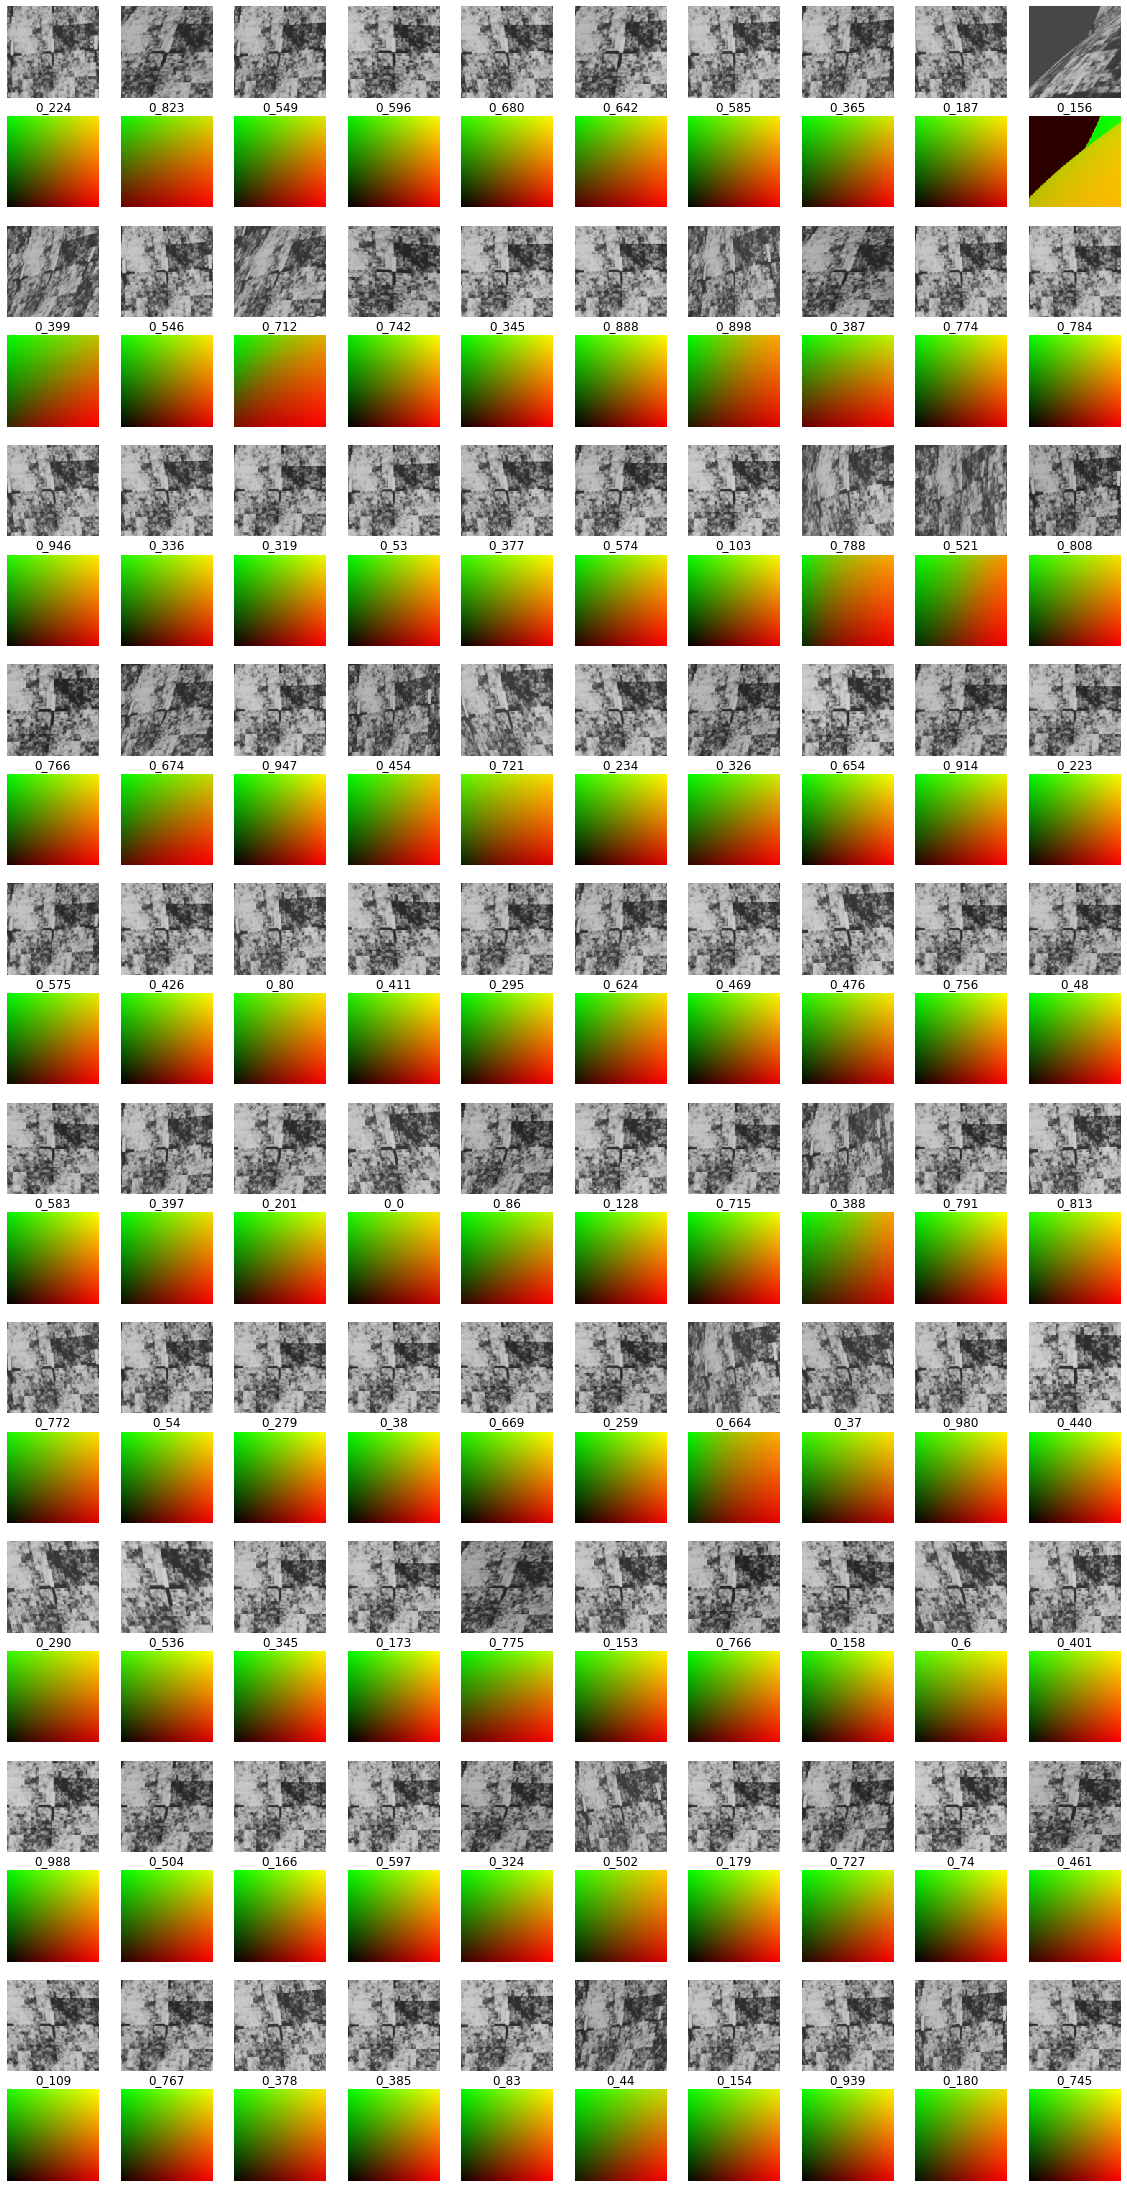

In [8]:
gridH = 20
gridW = 10
fig, axs = plt.subplots(gridH, gridW)

fig.set_size_inches(20, 20*(gridH/gridW))
for i, iMarker in enumerate(range(int(gridH/2))):
    marker = np.random.randint(0, len(imgsPerMaker))
    imgIds = np.random.randint(0, len(imgsPerMaker[marker]), size=(gridW,))
    for j, iImg in enumerate(imgIds):
        axs[i*2, j].imshow(imgsPerMaker[marker][iImg, ...], cmap="gray")
        axs[i*2, j].axis('off')
    
        axs[i*2+1, j].imshow(predToRGB(uvsPerMaker[marker][iImg, ...], normalize=True))
        axs[i*2+1, j].set_title("%d_%d" % (marker, iImg))
        axs[i*2+1, j].axis('off')

In [9]:
uNet = UnetLocalizer(channels=1, n_class=2)

2021-03-16 11:46:45,547 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [24]:
init = tf.global_variables_initializer()
uNet.sess.run(init)

In [11]:
inputX = np.zeros((10, 128,128,1))
logits = uNet.sess.run(uNet.logits, feed_dict={uNet.x:inputX, uNet.keep_prob:1})
pred_shape = logits.shape
pred_shape

(10, 88, 88, 2)

In [12]:
numData = imgsPerMaker[0].shape[0]
sizeTrain = numData - numTest

trainData = imgsPerMaker[0][:-numTest, ...]
trainUV = uvsPerMaker[0][:-numTest, ...]

testData = imgsPerMaker[0][-numTest:, ...]
testUV = uvsPerMaker[0][-numTest:, ...]

errInfo={
    'Train':[],
    'Validation':[]

}

In [13]:
saver = tf.train.Saver()

os.makedirs(outputFolder, exist_ok=True)
logFile = join(outputFolder, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [17]:
trainUVCropped = util.crop_to_shape(trainUV, (trainUV.shape[0], pred_shape[1], pred_shape[2], pred_shape[3]))
testUVCropped = util.crop_to_shape(testUV, (testUV.shape[0], pred_shape[1], pred_shape[2], pred_shape[3]))

In [15]:
pred_shape = logits.shape
pred_shape

(10, 88, 88, 2)

In [16]:
bestValErr= 100000

In [25]:
numEpoch = 10000
batchSize = 64
weight_decay = 5e-4
lr = 1e-3
saveStep = 500
iEpoch = 0
plotStep = 100

numBatch = int(np.ceil(sizeTrain / batchSize))

cfg = Config()

cfg.lrDecayStep = numBatch * 300
cfg.lrDecayRate = 0.5

uNet.cfg = cfg


In [26]:
while iEpoch < numEpoch:
    for iBatch in range(numBatch):
        fd = {
              uNet.x:trainData[iBatch*batchSize:(iBatch+1)*batchSize, :,:,:1],
              uNet.y:trainUVCropped[iBatch*batchSize:(iBatch+1)*batchSize, :,:,:],
              uNet.keep_prob: 1.,
              uNet.learning_rate: lr
             }
        
        _ = uNet.sess.run(uNet.optimizer, feed_dict=fd)

    
    evalTrain = evaluate(trainData[...,:1], trainUVCropped, uNet, batchSize=batchSize, perImgEval=False)    
    evalTest = evaluate(testData[...,:1], testUVCropped, uNet, batchSize=batchSize, perImgEval=False)    
    errInfo['Train'].append(evalTrain)
    errInfo['Validation'].append(evalTest)
    
    if not iEpoch % saveStep:
        save_path = saver.save(uNet.sess, join(outputFolder, "N03_UVExtractor_128_"+str(iEpoch).zfill(6)+".ckpt"))
        print("Saved check point to: ", save_path)
        
    infoStr = f'mean train err: %8.8g, max train err: %8.8g, mean val err: %8.8g, max val err:  %8.8g, learning rate: %8.8g' \
        % (evalTrain['MeanErr'], evalTrain['MaxErr'], evalTest['MeanErr'],  evalTest['MaxErr'], uNet.sess.run(uNet.learning_rate_decayed, feed_dict=fd))
    
    logger.info(infoStr)
    
    if bestValErr > evalTest['MeanErr']:
        bestValErr = evalTest['MeanErr']
        save_path = saver.save(uNet.sess, join(outputFolder, "N03_UVExtractor_128_best.ckpt"))
        print("Saved new best net's check point to: ", save_path)
        
        
    if iEpoch % plotStep == 0 and i:
        print(infoStr)
        fig, a_loss = plt.subplots()

        
        json.dump(errInfo, open(join(outputFolder, 'Errors.json'), 'w'))
        
        trainMeanErrs = [err['MeanErr'] for err in  errInfo['Train']]
        valMeanErrs = [err['MeanErr'] for err in errInfo['Validation']]
        plt.close('all')
        X = list(range(len(trainMeanErrs)))
        a_loss.plot(X, trainMeanErrs, label = "mean training error")
        a_loss.plot(X, valMeanErrs, label = "mean validation error")
        a_loss.set_yscale('log')
        
        a_loss.set_xlabel('iteration')
        # Set the y axis label of the current axis.
        a_loss.set_ylabel('mean localiztion error')
        a_loss.grid()
        a_loss.legend()
        fig.savefig(join(outputFolder,
                         'ErrCurve.png'),
                    dpi=256, transparent=False, bbox_inches='tight', )
        # to do: code to save the network weight with best validation results
        
    iEpoch += 1

Saved check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_000000.ckpt
2021-03-16 11:52:40,501 logger INFO mean train err: 0.17872927, max train err:  0.44114, mean val err: 0.17861777, max val err:  0.37417487, learning rate: 0.00099953648


2021-03-16 11:52:40,501 mean train err: 0.17872927, max train err:  0.44114, mean val err: 0.17861777, max val err:  0.37417487, learning rate: 0.00099953648


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
mean train err: 0.17872927, max train err:  0.44114, mean val err: 0.17861777, max val err:  0.37417487, learning rate: 0.00099953648
2021-03-16 11:52:42,773 logger INFO mean train err: 0.11346935, max train err: 0.43283038, mean val err: 0.11373012, max val err:  0.36632196, learning rate: 0.00099907303


2021-03-16 11:52:42,773 mean train err: 0.11346935, max train err: 0.43283038, mean val err: 0.11373012, max val err:  0.36632196, learning rate: 0.00099907303


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:52:44,755 logger INFO mean train err: 0.071632509, max train err: 0.39450989, mean val err: 0.071388078, max val err:  0.34953763, learning rate: 0.00099861005


2021-03-16 11:52:44,755 mean train err: 0.071632509, max train err: 0.39450989, mean val err: 0.071388078, max val err:  0.34953763, learning rate: 0.00099861005


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:52:46,730 logger INFO mean train err: 0.059483217, max train err: 0.40602546, mean val err: 0.059949369, max val err:  0.36495723, learning rate: 0.00099814695


2021-03-16 11:52:46,730 mean train err: 0.059483217, max train err: 0.40602546, mean val err: 0.059949369, max val err:  0.36495723, learning rate: 0.00099814695


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:52:48,680 logger INFO mean train err: 0.052149368, max train err: 0.4054615, mean val err: 0.052596254, max val err:  0.37941462, learning rate: 0.00099768431


2021-03-16 11:52:48,680 mean train err: 0.052149368, max train err: 0.4054615, mean val err: 0.052596254, max val err:  0.37941462, learning rate: 0.00099768431


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:52:50,602 logger INFO mean train err: 0.044319282, max train err: 0.40353025, mean val err: 0.044577838, max val err:  0.40303438, learning rate: 0.0009972218


2021-03-16 11:52:50,602 mean train err: 0.044319282, max train err: 0.40353025, mean val err: 0.044577838, max val err:  0.40303438, learning rate: 0.0009972218


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:52:52,520 logger INFO mean train err: 0.038503554, max train err: 0.40388417, mean val err: 0.038028386, max val err:  0.41046424, learning rate: 0.00099675963


2021-03-16 11:52:52,520 mean train err: 0.038503554, max train err: 0.40388417, mean val err: 0.038028386, max val err:  0.41046424, learning rate: 0.00099675963


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:52:54,458 logger INFO mean train err: 0.034747291, max train err: 0.43253854, mean val err: 0.034356896, max val err:  0.43445368, learning rate: 0.00099629746


2021-03-16 11:52:54,458 mean train err: 0.034747291, max train err: 0.43253854, mean val err: 0.034356896, max val err:  0.43445368, learning rate: 0.00099629746


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:52:56,355 logger INFO mean train err: 0.032563098, max train err: 0.45534456, mean val err: 0.032387964, max val err:  0.44929096, learning rate: 0.00099583564


2021-03-16 11:52:56,355 mean train err: 0.032563098, max train err: 0.45534456, mean val err: 0.032387964, max val err:  0.44929096, learning rate: 0.00099583564


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:52:58,225 logger INFO mean train err: 0.036603862, max train err: 0.48739626, mean val err: 0.036794778, max val err:  0.4697731, learning rate: 0.00099537394


2021-03-16 11:52:58,225 mean train err: 0.036603862, max train err: 0.48739626, mean val err: 0.036794778, max val err:  0.4697731, learning rate: 0.00099537394


2021-03-16 11:52:59,952 logger INFO mean train err: 0.030040305, max train err: 0.45385842, mean val err: 0.02979765, max val err:  0.4477021, learning rate: 0.00099491258


2021-03-16 11:52:59,952 mean train err: 0.030040305, max train err: 0.45385842, mean val err: 0.02979765, max val err:  0.4477021, learning rate: 0.00099491258


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:01,833 logger INFO mean train err: 0.029557666, max train err: 0.45114001, mean val err: 0.029047789, max val err:  0.44306405, learning rate: 0.00099445134


2021-03-16 11:53:01,833 mean train err: 0.029557666, max train err: 0.45114001, mean val err: 0.029047789, max val err:  0.44306405, learning rate: 0.00099445134


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:03,694 logger INFO mean train err: 0.028953208, max train err: 0.45234175, mean val err: 0.028427657, max val err:  0.44317016, learning rate: 0.00099399034


2021-03-16 11:53:03,694 mean train err: 0.028953208, max train err: 0.45234175, mean val err: 0.028427657, max val err:  0.44317016, learning rate: 0.00099399034


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:05,550 logger INFO mean train err: 0.027894083, max train err: 0.45404127, mean val err: 0.027391052, max val err:  0.44315408, learning rate: 0.00099352957


2021-03-16 11:53:05,550 mean train err: 0.027894083, max train err: 0.45404127, mean val err: 0.027391052, max val err:  0.44315408, learning rate: 0.00099352957


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:07,425 logger INFO mean train err: 0.027081562, max train err: 0.45294743, mean val err: 0.026582779, max val err:  0.44109707, learning rate: 0.00099306903


2021-03-16 11:53:07,425 mean train err: 0.027081562, max train err: 0.45294743, mean val err: 0.026582779, max val err:  0.44109707, learning rate: 0.00099306903


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:09,313 logger INFO mean train err: 0.026437683, max train err: 0.4554825, mean val err: 0.025950607, max val err:  0.44228115, learning rate: 0.00099260861


2021-03-16 11:53:09,313 mean train err: 0.026437683, max train err: 0.4554825, mean val err: 0.025950607, max val err:  0.44228115, learning rate: 0.00099260861


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:11,178 logger INFO mean train err: 0.025567956, max train err: 0.46004221, mean val err: 0.025180643, max val err:  0.44556973, learning rate: 0.00099214853


2021-03-16 11:53:11,178 mean train err: 0.025567956, max train err: 0.46004221, mean val err: 0.025180643, max val err:  0.44556973, learning rate: 0.00099214853


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:13,060 logger INFO mean train err: 0.02439181, max train err: 0.45899224, mean val err: 0.024127219, max val err:  0.44386425, learning rate: 0.00099168858


2021-03-16 11:53:13,060 mean train err: 0.02439181, max train err: 0.45899224, mean val err: 0.024127219, max val err:  0.44386425, learning rate: 0.00099168858


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:14,932 logger INFO mean train err: 0.023863718, max train err: 0.45912817, mean val err: 0.023675751, max val err:  0.44429033, learning rate: 0.00099122885


2021-03-16 11:53:14,932 mean train err: 0.023863718, max train err: 0.45912817, mean val err: 0.023675751, max val err:  0.44429033, learning rate: 0.00099122885


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:16,803 logger INFO mean train err: 0.024643978, max train err: 0.46691578, mean val err: 0.024611803, max val err:  0.45062909, learning rate: 0.00099076936


2021-03-16 11:53:16,803 mean train err: 0.024643978, max train err: 0.46691578, mean val err: 0.024611803, max val err:  0.45062909, learning rate: 0.00099076936


2021-03-16 11:53:18,552 logger INFO mean train err: 0.027605383, max train err: 0.47303073, mean val err: 0.027774396, max val err:  0.45545828, learning rate: 0.0009903101


2021-03-16 11:53:18,552 mean train err: 0.027605383, max train err: 0.47303073, mean val err: 0.027774396, max val err:  0.45545828, learning rate: 0.0009903101


2021-03-16 11:53:20,276 logger INFO mean train err: 0.024881774, max train err: 0.45564136, mean val err: 0.024963181, max val err:  0.4414718, learning rate: 0.00098985096


2021-03-16 11:53:20,276 mean train err: 0.024881774, max train err: 0.45564136, mean val err: 0.024963181, max val err:  0.4414718, learning rate: 0.00098985096


2021-03-16 11:53:21,978 logger INFO mean train err: 0.024244056, max train err: 0.44943679, mean val err: 0.024302142, max val err:  0.43729591, learning rate: 0.00098939217


2021-03-16 11:53:21,978 mean train err: 0.024244056, max train err: 0.44943679, mean val err: 0.024302142, max val err:  0.43729591, learning rate: 0.00098939217


2021-03-16 11:53:23,711 logger INFO mean train err: 0.022178466, max train err: 0.44410629, mean val err: 0.022134991, max val err:  0.43333974, learning rate: 0.00098893337


2021-03-16 11:53:23,711 mean train err: 0.022178466, max train err: 0.44410629, mean val err: 0.022134991, max val err:  0.43333974, learning rate: 0.00098893337


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:25,642 logger INFO mean train err: 0.021190042, max train err: 0.44004537, mean val err: 0.021084958, max val err:  0.43073994, learning rate: 0.00098847505


2021-03-16 11:53:25,642 mean train err: 0.021190042, max train err: 0.44004537, mean val err: 0.021084958, max val err:  0.43073994, learning rate: 0.00098847505


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:27,526 logger INFO mean train err: 0.02141543, max train err: 0.44172111, mean val err: 0.021378303, max val err:  0.42936999, learning rate: 0.00098801672


2021-03-16 11:53:27,526 mean train err: 0.02141543, max train err: 0.44172111, mean val err: 0.021378303, max val err:  0.42936999, learning rate: 0.00098801672


2021-03-16 11:53:29,334 logger INFO mean train err: 0.020909314, max train err: 0.43955949, mean val err: 0.020874973, max val err:  0.42533315, learning rate: 0.00098755886


2021-03-16 11:53:29,334 mean train err: 0.020909314, max train err: 0.43955949, mean val err: 0.020874973, max val err:  0.42533315, learning rate: 0.00098755886


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:31,229 logger INFO mean train err: 0.020201386, max train err: 0.43222187, mean val err: 0.020087657, max val err:  0.41749973, learning rate: 0.000987101


2021-03-16 11:53:31,229 mean train err: 0.020201386, max train err: 0.43222187, mean val err: 0.020087657, max val err:  0.41749973, learning rate: 0.000987101


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:33,155 logger INFO mean train err: 0.022258116, max train err: 0.42848093, mean val err: 0.02220026, max val err:  0.41301921, learning rate: 0.00098664337


2021-03-16 11:53:33,155 mean train err: 0.022258116, max train err: 0.42848093, mean val err: 0.02220026, max val err:  0.41301921, learning rate: 0.00098664337


2021-03-16 11:53:34,924 logger INFO mean train err: 0.020832855, max train err: 0.42902775, mean val err: 0.02085801, max val err:  0.41279103, learning rate: 0.00098618597


2021-03-16 11:53:34,924 mean train err: 0.020832855, max train err: 0.42902775, mean val err: 0.02085801, max val err:  0.41279103, learning rate: 0.00098618597


2021-03-16 11:53:36,659 logger INFO mean train err: 0.018950554, max train err: 0.42152711, mean val err: 0.018829341, max val err:  0.40380468, learning rate: 0.00098572881


2021-03-16 11:53:36,659 mean train err: 0.018950554, max train err: 0.42152711, mean val err: 0.018829341, max val err:  0.40380468, learning rate: 0.00098572881


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:38,556 logger INFO mean train err: 0.017836201, max train err: 0.41448791, mean val err: 0.017628973, max val err:  0.39623367, learning rate: 0.00098527188


2021-03-16 11:53:38,556 mean train err: 0.017836201, max train err: 0.41448791, mean val err: 0.017628973, max val err:  0.39623367, learning rate: 0.00098527188


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:40,459 logger INFO mean train err: 0.017169105, max train err: 0.40624373, mean val err: 0.016909261, max val err:  0.38768824, learning rate: 0.00098481507


2021-03-16 11:53:40,459 mean train err: 0.017169105, max train err: 0.40624373, mean val err: 0.016909261, max val err:  0.38768824, learning rate: 0.00098481507


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:42,371 logger INFO mean train err: 0.018400527, max train err: 0.40217324, mean val err: 0.01818842, max val err:  0.38300146, learning rate: 0.0009843586


2021-03-16 11:53:42,371 mean train err: 0.018400527, max train err: 0.40217324, mean val err: 0.01818842, max val err:  0.38300146, learning rate: 0.0009843586


2021-03-16 11:53:44,170 logger INFO mean train err: 0.019187973, max train err: 0.40421909, mean val err: 0.019083321, max val err:  0.38266182, learning rate: 0.00098390225


2021-03-16 11:53:44,170 mean train err: 0.019187973, max train err: 0.40421909, mean val err: 0.019083321, max val err:  0.38266182, learning rate: 0.00098390225


2021-03-16 11:53:45,989 logger INFO mean train err: 0.018392874, max train err: 0.40859892, mean val err: 0.018379947, max val err:  0.38072613, learning rate: 0.00098344614


2021-03-16 11:53:45,989 mean train err: 0.018392874, max train err: 0.40859892, mean val err: 0.018379947, max val err:  0.38072613, learning rate: 0.00098344614


2021-03-16 11:53:47,755 logger INFO mean train err: 0.017823788, max train err: 0.41126447, mean val err: 0.017795397, max val err:  0.37567821, learning rate: 0.00098299026


2021-03-16 11:53:47,755 mean train err: 0.017823788, max train err: 0.41126447, mean val err: 0.017795397, max val err:  0.37567821, learning rate: 0.00098299026


2021-03-16 11:53:49,502 logger INFO mean train err: 0.0166869, max train err: 0.40965919, mean val err: 0.016609786, max val err:  0.36875606, learning rate: 0.00098253461


2021-03-16 11:53:49,502 mean train err: 0.0166869, max train err: 0.40965919, mean val err: 0.016609786, max val err:  0.36875606, learning rate: 0.00098253461


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:51,367 logger INFO mean train err: 0.016054359, max train err: 0.40736262, mean val err: 0.015947839, max val err:  0.36223657, learning rate: 0.00098207907


2021-03-16 11:53:51,367 mean train err: 0.016054359, max train err: 0.40736262, mean val err: 0.015947839, max val err:  0.36223657, learning rate: 0.00098207907


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:53:53,320 logger INFO mean train err: 0.016118622, max train err: 0.40652945, mean val err: 0.016008573, max val err:  0.35662206, learning rate: 0.00098162389


2021-03-16 11:53:53,320 mean train err: 0.016118622, max train err: 0.40652945, mean val err: 0.016008573, max val err:  0.35662206, learning rate: 0.00098162389


2021-03-16 11:53:55,103 logger INFO mean train err: 0.016503879, max train err: 0.40808381, mean val err: 0.016440875, max val err:  0.35380148, learning rate: 0.00098116882


2021-03-16 11:53:55,103 mean train err: 0.016503879, max train err: 0.40808381, mean val err: 0.016440875, max val err:  0.35380148, learning rate: 0.00098116882


2021-03-16 11:53:56,863 logger INFO mean train err: 0.016992509, max train err: 0.41140885, mean val err: 0.016989055, max val err:  0.35196634, learning rate: 0.00098071399


2021-03-16 11:53:56,863 mean train err: 0.016992509, max train err: 0.41140885, mean val err: 0.016989055, max val err:  0.35196634, learning rate: 0.00098071399


2021-03-16 11:53:58,658 logger INFO mean train err: 0.017157654, max train err: 0.41377421, mean val err: 0.017174532, max val err:  0.34915242, learning rate: 0.00098025938


2021-03-16 11:53:58,658 mean train err: 0.017157654, max train err: 0.41377421, mean val err: 0.017174532, max val err:  0.34915242, learning rate: 0.00098025938


2021-03-16 11:54:00,413 logger INFO mean train err: 0.016545586, max train err: 0.41385388, mean val err: 0.016547212, max val err:  0.3457129, learning rate: 0.0009798049


2021-03-16 11:54:00,413 mean train err: 0.016545586, max train err: 0.41385388, mean val err: 0.016547212, max val err:  0.3457129, learning rate: 0.0009798049


2021-03-16 11:54:02,191 logger INFO mean train err: 0.015798343, max train err: 0.41313814, mean val err: 0.015783229, max val err:  0.34138103, learning rate: 0.00097935076


2021-03-16 11:54:02,191 mean train err: 0.015798343, max train err: 0.41313814, mean val err: 0.015783229, max val err:  0.34138103, learning rate: 0.00097935076


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:04,142 logger INFO mean train err: 0.015562631, max train err: 0.41222244, mean val err: 0.015545966, max val err:  0.33676333, learning rate: 0.00097889674


2021-03-16 11:54:04,142 mean train err: 0.015562631, max train err: 0.41222244, mean val err: 0.015545966, max val err:  0.33676333, learning rate: 0.00097889674


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:06,096 logger INFO mean train err: 0.015559386, max train err: 0.41289401, mean val err: 0.015560013, max val err:  0.33374227, learning rate: 0.00097844284


2021-03-16 11:54:06,096 mean train err: 0.015559386, max train err: 0.41289401, mean val err: 0.015560013, max val err:  0.33374227, learning rate: 0.00097844284


2021-03-16 11:54:07,904 logger INFO mean train err: 0.015875682, max train err: 0.4135846, mean val err: 0.015897414, max val err:  0.33023688, learning rate: 0.0009779894


2021-03-16 11:54:07,904 mean train err: 0.015875682, max train err: 0.4135846, mean val err: 0.015897414, max val err:  0.33023688, learning rate: 0.0009779894


2021-03-16 11:54:09,669 logger INFO mean train err: 0.015985182, max train err: 0.4155511, mean val err: 0.01602436, max val err:  0.32848887, learning rate: 0.00097753596


2021-03-16 11:54:09,669 mean train err: 0.015985182, max train err: 0.4155511, mean val err: 0.01602436, max val err:  0.32848887, learning rate: 0.00097753596


2021-03-16 11:54:11,458 logger INFO mean train err: 0.015556941, max train err: 0.41560204, mean val err: 0.015586806, max val err:  0.32411741, learning rate: 0.00097708288


2021-03-16 11:54:11,458 mean train err: 0.015556941, max train err: 0.41560204, mean val err: 0.015586806, max val err:  0.32411741, learning rate: 0.00097708288


2021-03-16 11:54:13,273 logger INFO mean train err: 0.014929308, max train err: 0.41525251, mean val err: 0.01494478, max val err:  0.32099669, learning rate: 0.0009766299


2021-03-16 11:54:13,273 mean train err: 0.014929308, max train err: 0.41525251, mean val err: 0.01494478, max val err:  0.32099669, learning rate: 0.0009766299


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:15,192 logger INFO mean train err: 0.014495716, max train err: 0.41484698, mean val err: 0.014499343, max val err:  0.31541818, learning rate: 0.00097617722


2021-03-16 11:54:15,192 mean train err: 0.014495716, max train err: 0.41484698, mean val err: 0.014499343, max val err:  0.31541818, learning rate: 0.00097617722


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:17,058 logger INFO mean train err: 0.014218493, max train err: 0.41466805, mean val err: 0.014218307, max val err:  0.30869648, learning rate: 0.0009757246


2021-03-16 11:54:17,058 mean train err: 0.014218493, max train err: 0.41466805, mean val err: 0.014218307, max val err:  0.30869648, learning rate: 0.0009757246


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:18,923 logger INFO mean train err: 0.014003959, max train err: 0.41478769, mean val err: 0.013996829, max val err:  0.3055761, learning rate: 0.00097527233


2021-03-16 11:54:18,923 mean train err: 0.014003959, max train err: 0.41478769, mean val err: 0.013996829, max val err:  0.3055761, learning rate: 0.00097527233


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:20,784 logger INFO mean train err: 0.014278313, max train err: 0.41559697, mean val err: 0.014276176, max val err:  0.29596614, learning rate: 0.00097482017


2021-03-16 11:54:20,784 mean train err: 0.014278313, max train err: 0.41559697, mean val err: 0.014276176, max val err:  0.29596614, learning rate: 0.00097482017


2021-03-16 11:54:22,492 logger INFO mean train err: 0.014662385, max train err: 0.41713373, mean val err: 0.014651378, max val err:  0.29777305, learning rate: 0.0009743683


2021-03-16 11:54:22,492 mean train err: 0.014662385, max train err: 0.41713373, mean val err: 0.014651378, max val err:  0.29777305, learning rate: 0.0009743683


2021-03-16 11:54:24,305 logger INFO mean train err: 0.015457661, max train err: 0.41876607, mean val err: 0.015431001, max val err:  0.29463733, learning rate: 0.00097391661


2021-03-16 11:54:24,305 mean train err: 0.015457661, max train err: 0.41876607, mean val err: 0.015431001, max val err:  0.29463733, learning rate: 0.00097391661


2021-03-16 11:54:26,049 logger INFO mean train err: 0.014747135, max train err: 0.41848341, mean val err: 0.0147125, max val err:  0.29126663, learning rate: 0.0009734651


2021-03-16 11:54:26,049 mean train err: 0.014747135, max train err: 0.41848341, mean val err: 0.0147125, max val err:  0.29126663, learning rate: 0.0009734651


2021-03-16 11:54:27,768 logger INFO mean train err: 0.01408346, max train err: 0.42083908, mean val err: 0.014046428, max val err:  0.29671732, learning rate: 0.00097301387


2021-03-16 11:54:27,768 mean train err: 0.01408346, max train err: 0.42083908, mean val err: 0.014046428, max val err:  0.29671732, learning rate: 0.00097301387


2021-03-16 11:54:29,550 logger INFO mean train err: 0.014167266, max train err: 0.4210759, mean val err: 0.014154143, max val err:  0.28924686, learning rate: 0.00097256276


2021-03-16 11:54:29,550 mean train err: 0.014167266, max train err: 0.4210759, mean val err: 0.014154143, max val err:  0.28924686, learning rate: 0.00097256276


2021-03-16 11:54:31,295 logger INFO mean train err: 0.014431165, max train err: 0.42083311, mean val err: 0.014420542, max val err:  0.28925628, learning rate: 0.00097211194


2021-03-16 11:54:31,295 mean train err: 0.014431165, max train err: 0.42083311, mean val err: 0.014420542, max val err:  0.28925628, learning rate: 0.00097211194


2021-03-16 11:54:33,109 logger INFO mean train err: 0.014294565, max train err: 0.42092449, mean val err: 0.014293375, max val err:  0.28984181, learning rate: 0.00097166124


2021-03-16 11:54:33,109 mean train err: 0.014294565, max train err: 0.42092449, mean val err: 0.014293375, max val err:  0.28984181, learning rate: 0.00097166124


2021-03-16 11:54:34,850 logger INFO mean train err: 0.013926817, max train err: 0.41822661, mean val err: 0.013922674, max val err:  0.28784713, learning rate: 0.00097121089


2021-03-16 11:54:34,850 mean train err: 0.013926817, max train err: 0.41822661, mean val err: 0.013922674, max val err:  0.28784713, learning rate: 0.00097121089


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:36,766 logger INFO mean train err: 0.013758792, max train err: 0.41850041, mean val err: 0.013763004, max val err:  0.28792597, learning rate: 0.00097076065


2021-03-16 11:54:36,766 mean train err: 0.013758792, max train err: 0.41850041, mean val err: 0.013763004, max val err:  0.28792597, learning rate: 0.00097076065


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:38,676 logger INFO mean train err: 0.013730339, max train err: 0.41694381, mean val err: 0.013739986, max val err:  0.28729302, learning rate: 0.00097031065


2021-03-16 11:54:38,676 mean train err: 0.013730339, max train err: 0.41694381, mean val err: 0.013739986, max val err:  0.28729302, learning rate: 0.00097031065


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:40,688 logger INFO mean train err: 0.013663595, max train err: 0.41649477, mean val err: 0.013673399, max val err:  0.28741932, learning rate: 0.00096986082


2021-03-16 11:54:40,688 mean train err: 0.013663595, max train err: 0.41649477, mean val err: 0.013673399, max val err:  0.28741932, learning rate: 0.00096986082


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:42,559 logger INFO mean train err: 0.013517421, max train err: 0.41538647, mean val err: 0.013534767, max val err:  0.28685637, learning rate: 0.00096941122


2021-03-16 11:54:42,559 mean train err: 0.013517421, max train err: 0.41538647, mean val err: 0.013534767, max val err:  0.28685637, learning rate: 0.00096941122


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:44,438 logger INFO mean train err: 0.013607147, max train err: 0.41547848, mean val err: 0.013620615, max val err:  0.2901151, learning rate: 0.0009689618


2021-03-16 11:54:44,438 mean train err: 0.013607147, max train err: 0.41547848, mean val err: 0.013620615, max val err:  0.2901151, learning rate: 0.0009689618


2021-03-16 11:54:46,192 logger INFO mean train err: 0.013614813, max train err: 0.41307855, mean val err: 0.013637196, max val err:  0.28892113, learning rate: 0.00096851267


2021-03-16 11:54:46,192 mean train err: 0.013614813, max train err: 0.41307855, mean val err: 0.013637196, max val err:  0.28892113, learning rate: 0.00096851267


2021-03-16 11:54:47,935 logger INFO mean train err: 0.013374138, max train err: 0.41349474, mean val err: 0.013393573, max val err:  0.28968112, learning rate: 0.00096806372


2021-03-16 11:54:47,935 mean train err: 0.013374138, max train err: 0.41349474, mean val err: 0.013393573, max val err:  0.28968112, learning rate: 0.00096806372


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:49,935 logger INFO mean train err: 0.013036654, max train err: 0.41133194, mean val err: 0.013050786, max val err:  0.28954765, learning rate: 0.00096761493


2021-03-16 11:54:49,935 mean train err: 0.013036654, max train err: 0.41133194, mean val err: 0.013050786, max val err:  0.28954765, learning rate: 0.00096761493


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:51,848 logger INFO mean train err: 0.012901399, max train err: 0.41189104, mean val err: 0.012926241, max val err:  0.29191372, learning rate: 0.00096716633


2021-03-16 11:54:51,848 mean train err: 0.012901399, max train err: 0.41189104, mean val err: 0.012926241, max val err:  0.29191372, learning rate: 0.00096716633


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:54:53,757 logger INFO mean train err: 0.013002635, max train err: 0.4094693, mean val err: 0.013032773, max val err:  0.28976829, learning rate: 0.00096671807


2021-03-16 11:54:53,757 mean train err: 0.013002635, max train err: 0.4094693, mean val err: 0.013032773, max val err:  0.28976829, learning rate: 0.00096671807


2021-03-16 11:54:55,551 logger INFO mean train err: 0.013118853, max train err: 0.40945983, mean val err: 0.013148257, max val err:  0.29056833, learning rate: 0.00096626987


2021-03-16 11:54:55,551 mean train err: 0.013118853, max train err: 0.40945983, mean val err: 0.013148257, max val err:  0.29056833, learning rate: 0.00096626987


2021-03-16 11:54:57,317 logger INFO mean train err: 0.013126381, max train err: 0.40876331, mean val err: 0.013158822, max val err:  0.291808, learning rate: 0.00096582202


2021-03-16 11:54:57,317 mean train err: 0.013126381, max train err: 0.40876331, mean val err: 0.013158822, max val err:  0.291808, learning rate: 0.00096582202


2021-03-16 11:54:59,095 logger INFO mean train err: 0.012754877, max train err: 0.40744243, mean val err: 0.012777799, max val err:  0.29229613, learning rate: 0.00096537423


2021-03-16 11:54:59,095 mean train err: 0.012754877, max train err: 0.40744243, mean val err: 0.012777799, max val err:  0.29229613, learning rate: 0.00096537423


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:01,065 logger INFO mean train err: 0.012495306, max train err: 0.4040604, mean val err: 0.012523516, max val err:  0.29067923, learning rate: 0.00096492679


2021-03-16 11:55:01,065 mean train err: 0.012495306, max train err: 0.4040604, mean val err: 0.012523516, max val err:  0.29067923, learning rate: 0.00096492679


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:03,064 logger INFO mean train err: 0.012396722, max train err: 0.40524385, mean val err: 0.012428493, max val err:  0.29339771, learning rate: 0.0009644794


2021-03-16 11:55:03,064 mean train err: 0.012396722, max train err: 0.40524385, mean val err: 0.012428493, max val err:  0.29339771, learning rate: 0.0009644794


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:04,993 logger INFO mean train err: 0.012520579, max train err: 0.4025934, mean val err: 0.012550909, max val err:  0.29239073, learning rate: 0.00096403231


2021-03-16 11:55:04,993 mean train err: 0.012520579, max train err: 0.4025934, mean val err: 0.012550909, max val err:  0.29239073, learning rate: 0.00096403231


2021-03-16 11:55:06,753 logger INFO mean train err: 0.012790902, max train err: 0.40470022, mean val err: 0.01284134, max val err:  0.29456354, learning rate: 0.00096358545


2021-03-16 11:55:06,753 mean train err: 0.012790902, max train err: 0.40470022, mean val err: 0.01284134, max val err:  0.29456354, learning rate: 0.00096358545


2021-03-16 11:55:08,587 logger INFO mean train err: 0.012748938, max train err: 0.40279334, mean val err: 0.012796303, max val err:  0.29055984, learning rate: 0.00096313877


2021-03-16 11:55:08,587 mean train err: 0.012748938, max train err: 0.40279334, mean val err: 0.012796303, max val err:  0.29055984, learning rate: 0.00096313877


2021-03-16 11:55:10,346 logger INFO mean train err: 0.012456676, max train err: 0.40419258, mean val err: 0.012499818, max val err:  0.294076, learning rate: 0.00096269225


2021-03-16 11:55:10,346 mean train err: 0.012456676, max train err: 0.40419258, mean val err: 0.012499818, max val err:  0.294076, learning rate: 0.00096269225


2021-03-16 11:55:12,115 logger INFO mean train err: 0.012197851, max train err: 0.40293825, mean val err: 0.01223431, max val err:  0.29369742, learning rate: 0.00096224598


2021-03-16 11:55:12,115 mean train err: 0.012197851, max train err: 0.40293825, mean val err: 0.01223431, max val err:  0.29369742, learning rate: 0.00096224598


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:14,062 logger INFO mean train err: 0.011874608, max train err: 0.402601, mean val err: 0.011908875, max val err:  0.29144147, learning rate: 0.00096179993


2021-03-16 11:55:14,062 mean train err: 0.011874608, max train err: 0.402601, mean val err: 0.011908875, max val err:  0.29144147, learning rate: 0.00096179993


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:15,964 logger INFO mean train err: 0.011774177, max train err: 0.40173825, mean val err: 0.011811685, max val err:  0.29401117, learning rate: 0.000961354


2021-03-16 11:55:15,964 mean train err: 0.011774177, max train err: 0.40173825, mean val err: 0.011811685, max val err:  0.29401117, learning rate: 0.000961354


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:17,946 logger INFO mean train err: 0.011802112, max train err: 0.40200208, mean val err: 0.011838491, max val err:  0.29401955, learning rate: 0.00096090842


2021-03-16 11:55:17,946 mean train err: 0.011802112, max train err: 0.40200208, mean val err: 0.011838491, max val err:  0.29401955, learning rate: 0.00096090842


2021-03-16 11:55:19,711 logger INFO mean train err: 0.011991998, max train err: 0.40038721, mean val err: 0.01203766, max val err:  0.29059076, learning rate: 0.0009604629


2021-03-16 11:55:19,711 mean train err: 0.011991998, max train err: 0.40038721, mean val err: 0.01203766, max val err:  0.29059076, learning rate: 0.0009604629


2021-03-16 11:55:21,458 logger INFO mean train err: 0.01258494, max train err: 0.40307279, mean val err: 0.012649658, max val err:  0.29933509, learning rate: 0.00096001767


2021-03-16 11:55:21,458 mean train err: 0.01258494, max train err: 0.40307279, mean val err: 0.012649658, max val err:  0.29933509, learning rate: 0.00096001767


2021-03-16 11:55:23,243 logger INFO mean train err: 0.01233296, max train err: 0.40179237, mean val err: 0.012393524, max val err:  0.29532174, learning rate: 0.00095957262


2021-03-16 11:55:23,243 mean train err: 0.01233296, max train err: 0.40179237, mean val err: 0.012393524, max val err:  0.29532174, learning rate: 0.00095957262


2021-03-16 11:55:25,031 logger INFO mean train err: 0.011743444, max train err: 0.40113962, mean val err: 0.011787213, max val err:  0.29512757, learning rate: 0.00095912785


2021-03-16 11:55:25,031 mean train err: 0.011743444, max train err: 0.40113962, mean val err: 0.011787213, max val err:  0.29512757, learning rate: 0.00095912785


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:27,012 logger INFO mean train err: 0.011242637, max train err: 0.39887543, mean val err: 0.011284524, max val err:  0.29266195, learning rate: 0.0009586832


2021-03-16 11:55:27,012 mean train err: 0.011242637, max train err: 0.39887543, mean val err: 0.011284524, max val err:  0.29266195, learning rate: 0.0009586832


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:28,943 logger INFO mean train err: 0.011338073, max train err: 0.39926951, mean val err: 0.011386544, max val err:  0.2991765, learning rate: 0.00095823879


2021-03-16 11:55:28,943 mean train err: 0.011338073, max train err: 0.39926951, mean val err: 0.011386544, max val err:  0.2991765, learning rate: 0.00095823879


2021-03-16 11:55:30,708 logger INFO mean train err: 0.011325194, max train err: 0.39764887, mean val err: 0.011371051, max val err:  0.29651231, learning rate: 0.00095779455


2021-03-16 11:55:30,708 mean train err: 0.011325194, max train err: 0.39764887, mean val err: 0.011371051, max val err:  0.29651231, learning rate: 0.00095779455


2021-03-16 11:55:32,485 logger INFO mean train err: 0.011326515, max train err: 0.39776904, mean val err: 0.011367575, max val err:  0.29554082, learning rate: 0.0009573506


2021-03-16 11:55:32,485 mean train err: 0.011326515, max train err: 0.39776904, mean val err: 0.011367575, max val err:  0.29554082, learning rate: 0.0009573506


2021-03-16 11:55:34,241 logger INFO mean train err: 0.011340779, max train err: 0.39541934, mean val err: 0.011384769, max val err:  0.29422203, learning rate: 0.0009569067


2021-03-16 11:55:34,241 mean train err: 0.011340779, max train err: 0.39541934, mean val err: 0.011384769, max val err:  0.29422203, learning rate: 0.0009569067


2021-03-16 11:55:36,033 logger INFO mean train err: 0.011408202, max train err: 0.39745964, mean val err: 0.011453997, max val err:  0.29522384, learning rate: 0.00095646322


2021-03-16 11:55:36,033 mean train err: 0.011408202, max train err: 0.39745964, mean val err: 0.011453997, max val err:  0.29522384, learning rate: 0.00095646322


2021-03-16 11:55:37,780 logger INFO mean train err: 0.011560616, max train err: 0.3928133, mean val err: 0.011614423, max val err:  0.29146854, learning rate: 0.00095601974


2021-03-16 11:55:37,780 mean train err: 0.011560616, max train err: 0.3928133, mean val err: 0.011614423, max val err:  0.29146854, learning rate: 0.00095601974


2021-03-16 11:55:39,558 logger INFO mean train err: 0.012862765, max train err: 0.40240313, mean val err: 0.01293747, max val err:  0.31729779, learning rate: 0.00095557666


2021-03-16 11:55:39,558 mean train err: 0.012862765, max train err: 0.40240313, mean val err: 0.01293747, max val err:  0.31729779, learning rate: 0.00095557666


2021-03-16 11:55:41,380 logger INFO mean train err: 0.011527551, max train err: 0.39474596, mean val err: 0.011602925, max val err:  0.28245029, learning rate: 0.00095513358


2021-03-16 11:55:41,380 mean train err: 0.011527551, max train err: 0.39474596, mean val err: 0.011602925, max val err:  0.28245029, learning rate: 0.00095513358


2021-03-16 11:55:43,140 logger INFO mean train err: 0.011426143, max train err: 0.39673845, mean val err: 0.011504952, max val err:  0.29163585, learning rate: 0.00095469085


2021-03-16 11:55:43,140 mean train err: 0.011426143, max train err: 0.39673845, mean val err: 0.011504952, max val err:  0.29163585, learning rate: 0.00095469085


2021-03-16 11:55:44,884 logger INFO mean train err: 0.010468825, max train err: 0.39578565, mean val err: 0.010493446, max val err:  0.29182961, learning rate: 0.0009542483


2021-03-16 11:55:44,884 mean train err: 0.010468825, max train err: 0.39578565, mean val err: 0.010493446, max val err:  0.29182961, learning rate: 0.0009542483


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
mean train err: 0.010468825, max train err: 0.39578565, mean val err: 0.010493446, max val err:  0.29182961, learning rate: 0.0009542483
2021-03-16 11:55:47,206 logger INFO mean train err: 0.0099022433, max train err: 0.40145726, mean val err: 0.0099255188, max val err:  0.31802875, learning rate: 0.00095380598


2021-03-16 11:55:47,206 mean train err: 0.0099022433, max train err: 0.40145726, mean val err: 0.0099255188, max val err:  0.31802875, learning rate: 0.00095380598


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:49,131 logger INFO mean train err: 0.010813085, max train err: 0.39323967, mean val err: 0.010878065, max val err:  0.27990485, learning rate: 0.00095336378


2021-03-16 11:55:49,131 mean train err: 0.010813085, max train err: 0.39323967, mean val err: 0.010878065, max val err:  0.27990485, learning rate: 0.00095336378


2021-03-16 11:55:50,863 logger INFO mean train err: 0.01086829, max train err: 0.39271317, mean val err: 0.01095606, max val err:  0.27066612, learning rate: 0.00095292187


2021-03-16 11:55:50,863 mean train err: 0.01086829, max train err: 0.39271317, mean val err: 0.01095606, max val err:  0.27066612, learning rate: 0.00095292187


2021-03-16 11:55:52,655 logger INFO mean train err: 0.011989979, max train err: 0.39815083, mean val err: 0.012055852, max val err:  0.27522402, learning rate: 0.00095248007


2021-03-16 11:55:52,655 mean train err: 0.011989979, max train err: 0.39815083, mean val err: 0.012055852, max val err:  0.27522402, learning rate: 0.00095248007


2021-03-16 11:55:54,511 logger INFO mean train err: 0.011499839, max train err: 0.40117117, mean val err: 0.01160065, max val err:  0.29561413, learning rate: 0.00095203856


2021-03-16 11:55:54,511 mean train err: 0.011499839, max train err: 0.40117117, mean val err: 0.01160065, max val err:  0.29561413, learning rate: 0.00095203856


2021-03-16 11:55:56,296 logger INFO mean train err: 0.0097333218, max train err: 0.39632095, mean val err: 0.0098207858, max val err:  0.27810881, learning rate: 0.00095159718


2021-03-16 11:55:56,296 mean train err: 0.0097333218, max train err: 0.39632095, mean val err: 0.0098207858, max val err:  0.27810881, learning rate: 0.00095159718


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:55:58,238 logger INFO mean train err: 0.0088872613, max train err: 0.39559076, mean val err: 0.0089512516, max val err:  0.28311591, learning rate: 0.00095115608


2021-03-16 11:55:58,238 mean train err: 0.0088872613, max train err: 0.39559076, mean val err: 0.0089512516, max val err:  0.28311591, learning rate: 0.00095115608


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:00,199 logger INFO mean train err: 0.0092124501, max train err: 0.3939779, mean val err: 0.0092922683, max val err:  0.27398962, learning rate: 0.0009507151


2021-03-16 11:56:00,199 mean train err: 0.0092124501, max train err: 0.3939779, mean val err: 0.0092922683, max val err:  0.27398962, learning rate: 0.0009507151


2021-03-16 11:56:01,961 logger INFO mean train err: 0.0096393118, max train err: 0.39656155, mean val err: 0.0097329749, max val err:  0.27588508, learning rate: 0.00095027447


2021-03-16 11:56:01,961 mean train err: 0.0096393118, max train err: 0.39656155, mean val err: 0.0097329749, max val err:  0.27588508, learning rate: 0.00095027447


2021-03-16 11:56:03,744 logger INFO mean train err: 0.009676702, max train err: 0.39261027, mean val err: 0.0097712889, max val err:  0.27016543, learning rate: 0.00094983383


2021-03-16 11:56:03,744 mean train err: 0.009676702, max train err: 0.39261027, mean val err: 0.0097712889, max val err:  0.27016543, learning rate: 0.00094983383


2021-03-16 11:56:05,544 logger INFO mean train err: 0.0093177378, max train err: 0.39135909, mean val err: 0.0094037123, max val err:  0.26731997, learning rate: 0.00094939361


2021-03-16 11:56:05,544 mean train err: 0.0093177378, max train err: 0.39135909, mean val err: 0.0094037123, max val err:  0.26731997, learning rate: 0.00094939361


2021-03-16 11:56:07,314 logger INFO mean train err: 0.0090672476, max train err: 0.38931998, mean val err: 0.0091464104, max val err:  0.26680892, learning rate: 0.00094895344


2021-03-16 11:56:07,314 mean train err: 0.0090672476, max train err: 0.38931998, mean val err: 0.0091464104, max val err:  0.26680892, learning rate: 0.00094895344


2021-03-16 11:56:09,097 logger INFO mean train err: 0.0088608899, max train err: 0.3879568, mean val err: 0.0089361985, max val err:  0.26528259, learning rate: 0.00094851363


2021-03-16 11:56:09,097 mean train err: 0.0088608899, max train err: 0.3879568, mean val err: 0.0089361985, max val err:  0.26528259, learning rate: 0.00094851363


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:11,046 logger INFO mean train err: 0.0086244888, max train err: 0.3868785, mean val err: 0.0086966968, max val err:  0.26407576, learning rate: 0.00094807387


2021-03-16 11:56:11,046 mean train err: 0.0086244888, max train err: 0.3868785, mean val err: 0.0086966968, max val err:  0.26407576, learning rate: 0.00094807387


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:12,968 logger INFO mean train err: 0.0083809152, max train err: 0.38428464, mean val err: 0.0084493197, max val err:  0.25878133, learning rate: 0.00094763434


2021-03-16 11:56:12,968 mean train err: 0.0083809152, max train err: 0.38428464, mean val err: 0.0084493197, max val err:  0.25878133, learning rate: 0.00094763434


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:14,921 logger INFO mean train err: 0.0081422334, max train err: 0.38306337, mean val err: 0.0082078599, max val err:  0.25707169, learning rate: 0.00094719505


2021-03-16 11:56:14,921 mean train err: 0.0081422334, max train err: 0.38306337, mean val err: 0.0082078599, max val err:  0.25707169, learning rate: 0.00094719505


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:16,880 logger INFO mean train err: 0.0078866472, max train err: 0.3805496, mean val err: 0.0079467948, max val err:  0.25171827, learning rate: 0.00094675593


2021-03-16 11:56:16,880 mean train err: 0.0078866472, max train err: 0.3805496, mean val err: 0.0079467948, max val err:  0.25171827, learning rate: 0.00094675593


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:18,890 logger INFO mean train err: 0.0076579025, max train err: 0.37927682, mean val err: 0.0077124251, max val err:  0.25009705, learning rate: 0.00094631704


2021-03-16 11:56:18,890 mean train err: 0.0076579025, max train err: 0.37927682, mean val err: 0.0077124251, max val err:  0.25009705, learning rate: 0.00094631704


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:20,921 logger INFO mean train err: 0.0074947475, max train err: 0.37663323, mean val err: 0.0075447118, max val err:  0.24612049, learning rate: 0.00094587839


2021-03-16 11:56:20,921 mean train err: 0.0074947475, max train err: 0.37663323, mean val err: 0.0075447118, max val err:  0.24612049, learning rate: 0.00094587839


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:22,870 logger INFO mean train err: 0.0074118807, max train err: 0.37541297, mean val err: 0.0074614376, max val err:  0.24718863, learning rate: 0.00094543991


2021-03-16 11:56:22,870 mean train err: 0.0074118807, max train err: 0.37541297, mean val err: 0.0074614376, max val err:  0.24718863, learning rate: 0.00094543991


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:24,844 logger INFO mean train err: 0.0073892814, max train err: 0.37282564, mean val err: 0.0074443353, max val err:  0.24647539, learning rate: 0.00094500167


2021-03-16 11:56:24,844 mean train err: 0.0073892814, max train err: 0.37282564, mean val err: 0.0074443353, max val err:  0.24647539, learning rate: 0.00094500167


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:26,765 logger INFO mean train err: 0.0073734862, max train err: 0.37062714, mean val err: 0.0074330852, max val err:  0.24768782, learning rate: 0.0009445636


2021-03-16 11:56:26,765 mean train err: 0.0073734862, max train err: 0.37062714, mean val err: 0.0074330852, max val err:  0.24768782, learning rate: 0.0009445636


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:28,671 logger INFO mean train err: 0.0073412937, max train err: 0.36783521, mean val err: 0.0074083979, max val err:  0.24531826, learning rate: 0.0009441257


2021-03-16 11:56:28,671 mean train err: 0.0073412937, max train err: 0.36783521, mean val err: 0.0074083979, max val err:  0.24531826, learning rate: 0.0009441257


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:30,580 logger INFO mean train err: 0.0073536191, max train err: 0.36727299, mean val err: 0.0074363525, max val err:  0.24975661, learning rate: 0.00094368809


2021-03-16 11:56:30,580 mean train err: 0.0073536191, max train err: 0.36727299, mean val err: 0.0074363525, max val err:  0.24975661, learning rate: 0.00094368809


2021-03-16 11:56:32,399 logger INFO mean train err: 0.007325406, max train err: 0.36493245, mean val err: 0.0074107927, max val err:  0.25295369, learning rate: 0.0009432506


2021-03-16 11:56:32,399 mean train err: 0.007325406, max train err: 0.36493245, mean val err: 0.0074107927, max val err:  0.25295369, learning rate: 0.0009432506


2021-03-16 11:56:34,216 logger INFO mean train err: 0.0072184013, max train err: 0.36018285, mean val err: 0.0072681327, max val err:  0.25246255, learning rate: 0.00094281335


2021-03-16 11:56:34,216 mean train err: 0.0072184013, max train err: 0.36018285, mean val err: 0.0072681327, max val err:  0.25246255, learning rate: 0.00094281335


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:36,191 logger INFO mean train err: 0.0076694491, max train err: 0.35347764, mean val err: 0.0076637644, max val err:  0.24613647, learning rate: 0.00094237627


2021-03-16 11:56:36,191 mean train err: 0.0076694491, max train err: 0.35347764, mean val err: 0.0076637644, max val err:  0.24613647, learning rate: 0.00094237627


2021-03-16 11:56:38,110 logger INFO mean train err: 0.0073306446, max train err: 0.35349252, mean val err: 0.00735954, max val err:  0.2500877, learning rate: 0.00094193948


2021-03-16 11:56:38,110 mean train err: 0.0073306446, max train err: 0.35349252, mean val err: 0.00735954, max val err:  0.2500877, learning rate: 0.00094193948


2021-03-16 11:56:40,000 logger INFO mean train err: 0.007058117, max train err: 0.35317835, mean val err: 0.0071302049, max val err:  0.24433922, learning rate: 0.00094150275


2021-03-16 11:56:40,000 mean train err: 0.007058117, max train err: 0.35317835, mean val err: 0.0071302049, max val err:  0.24433922, learning rate: 0.00094150275


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:42,154 logger INFO mean train err: 0.0071003703, max train err: 0.35237114, mean val err: 0.0071995416, max val err:  0.24859043, learning rate: 0.0009410663


2021-03-16 11:56:42,154 mean train err: 0.0071003703, max train err: 0.35237114, mean val err: 0.0071995416, max val err:  0.24859043, learning rate: 0.0009410663


2021-03-16 11:56:44,001 logger INFO mean train err: 0.0087810323, max train err: 0.33663903, mean val err: 0.0087185448, max val err:  0.23047112, learning rate: 0.00094063004


2021-03-16 11:56:44,001 mean train err: 0.0087810323, max train err: 0.33663903, mean val err: 0.0087185448, max val err:  0.23047112, learning rate: 0.00094063004


2021-03-16 11:56:45,853 logger INFO mean train err: 0.0093703915, max train err: 0.341452, mean val err: 0.0092812918, max val err:  0.24688066, learning rate: 0.00094019406


2021-03-16 11:56:45,853 mean train err: 0.0093703915, max train err: 0.341452, mean val err: 0.0092812918, max val err:  0.24688066, learning rate: 0.00094019406


2021-03-16 11:56:47,600 logger INFO mean train err: 0.0081991985, max train err: 0.35722472, mean val err: 0.0083535094, max val err:  0.27991723, learning rate: 0.00093975815


2021-03-16 11:56:47,600 mean train err: 0.0081991985, max train err: 0.35722472, mean val err: 0.0083535094, max val err:  0.27991723, learning rate: 0.00093975815


2021-03-16 11:56:49,433 logger INFO mean train err: 0.0074901509, max train err: 0.34248569, mean val err: 0.0075019484, max val err:  0.18786547, learning rate: 0.00093932252


2021-03-16 11:56:49,433 mean train err: 0.0074901509, max train err: 0.34248569, mean val err: 0.0075019484, max val err:  0.18786547, learning rate: 0.00093932252


2021-03-16 11:56:51,574 logger INFO mean train err: 0.007052361, max train err: 0.3506384, mean val err: 0.0071678713, max val err:  0.23641759, learning rate: 0.00093888707


2021-03-16 11:56:51,574 mean train err: 0.007052361, max train err: 0.3506384, mean val err: 0.0071678713, max val err:  0.23641759, learning rate: 0.00093888707


2021-03-16 11:56:53,365 logger INFO mean train err: 0.0075467274, max train err: 0.34943179, mean val err: 0.00772307, max val err:  0.23952219, learning rate: 0.00093845185


2021-03-16 11:56:53,365 mean train err: 0.0075467274, max train err: 0.34943179, mean val err: 0.00772307, max val err:  0.23952219, learning rate: 0.00093845185


2021-03-16 11:56:55,772 logger INFO mean train err: 0.0069710951, max train err: 0.35392505, mean val err: 0.0071158287, max val err:  0.23221006, learning rate: 0.00093801675


2021-03-16 11:56:55,772 mean train err: 0.0069710951, max train err: 0.35392505, mean val err: 0.0071158287, max val err:  0.23221006, learning rate: 0.00093801675


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:56:57,927 logger INFO mean train err: 0.0071048154, max train err: 0.34348197, mean val err: 0.0072648689, max val err:  0.24469387, learning rate: 0.00093758199


2021-03-16 11:56:57,927 mean train err: 0.0071048154, max train err: 0.34348197, mean val err: 0.0072648689, max val err:  0.24469387, learning rate: 0.00093758199


2021-03-16 11:56:59,680 logger INFO mean train err: 0.0073311622, max train err: 0.33815058, mean val err: 0.0075089155, max val err:  0.23589107, learning rate: 0.0009371473


2021-03-16 11:56:59,680 mean train err: 0.0073311622, max train err: 0.33815058, mean val err: 0.0075089155, max val err:  0.23589107, learning rate: 0.0009371473


2021-03-16 11:57:01,502 logger INFO mean train err: 0.0073958227, max train err: 0.34383871, mean val err: 0.0075819643, max val err:  0.2327173, learning rate: 0.0009367129


2021-03-16 11:57:01,502 mean train err: 0.0073958227, max train err: 0.34383871, mean val err: 0.0075819643, max val err:  0.2327173, learning rate: 0.0009367129


2021-03-16 11:57:03,226 logger INFO mean train err: 0.0074669554, max train err: 0.34130656, mean val err: 0.0076564912, max val err:  0.23052412, learning rate: 0.00093627861


2021-03-16 11:57:03,226 mean train err: 0.0074669554, max train err: 0.34130656, mean val err: 0.0076564912, max val err:  0.23052412, learning rate: 0.00093627861


2021-03-16 11:57:04,959 logger INFO mean train err: 0.0067483214, max train err: 0.33916023, mean val err: 0.0069094526, max val err:  0.22407809, learning rate: 0.00093584461


2021-03-16 11:57:04,959 mean train err: 0.0067483214, max train err: 0.33916023, mean val err: 0.0069094526, max val err:  0.22407809, learning rate: 0.00093584461


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:57:07,372 logger INFO mean train err: 0.0071261075, max train err: 0.34140271, mean val err: 0.0073072628, max val err:  0.23401217, learning rate: 0.00093541079


2021-03-16 11:57:07,372 mean train err: 0.0071261075, max train err: 0.34140271, mean val err: 0.0073072628, max val err:  0.23401217, learning rate: 0.00093541079


2021-03-16 11:57:09,445 logger INFO mean train err: 0.0082716667, max train err: 0.329789, mean val err: 0.0082469455, max val err:  0.22044728, learning rate: 0.00093497708


2021-03-16 11:57:09,445 mean train err: 0.0082716667, max train err: 0.329789, mean val err: 0.0082469455, max val err:  0.22044728, learning rate: 0.00093497708


2021-03-16 11:57:11,393 logger INFO mean train err: 0.006557603, max train err: 0.33956851, mean val err: 0.0067057955, max val err:  0.26166543, learning rate: 0.00093454373


2021-03-16 11:57:11,393 mean train err: 0.006557603, max train err: 0.33956851, mean val err: 0.0067057955, max val err:  0.26166543, learning rate: 0.00093454373


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:57:13,340 logger INFO mean train err: 0.0084854327, max train err: 0.34672128, mean val err: 0.0086998708, max val err:  0.22578152, learning rate: 0.00093411043


2021-03-16 11:57:13,340 mean train err: 0.0084854327, max train err: 0.34672128, mean val err: 0.0086998708, max val err:  0.22578152, learning rate: 0.00093411043


2021-03-16 11:57:15,093 logger INFO mean train err: 0.0079779621, max train err: 0.3571405, mean val err: 0.0081912672, max val err:  0.23703073, learning rate: 0.00093367748


2021-03-16 11:57:15,093 mean train err: 0.0079779621, max train err: 0.3571405, mean val err: 0.0081912672, max val err:  0.23703073, learning rate: 0.00093367748


2021-03-16 11:57:16,848 logger INFO mean train err: 0.0067805177, max train err: 0.3411141, mean val err: 0.0069497757, max val err:  0.24211592, learning rate: 0.00093324465


2021-03-16 11:57:16,848 mean train err: 0.0067805177, max train err: 0.3411141, mean val err: 0.0069497757, max val err:  0.24211592, learning rate: 0.00093324465


2021-03-16 11:57:18,661 logger INFO mean train err: 0.0088482671, max train err: 0.31460985, mean val err: 0.0087935225, max val err:  0.21122897, learning rate: 0.00093281199


2021-03-16 11:57:18,661 mean train err: 0.0088482671, max train err: 0.31460985, mean val err: 0.0087935225, max val err:  0.21122897, learning rate: 0.00093281199


2021-03-16 11:57:20,606 logger INFO mean train err: 0.0063639957, max train err: 0.32576702, mean val err: 0.0064832981, max val err:  0.26807398, learning rate: 0.00093237957


2021-03-16 11:57:20,606 mean train err: 0.0063639957, max train err: 0.32576702, mean val err: 0.0064832981, max val err:  0.26807398, learning rate: 0.00093237957


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:57:22,583 logger INFO mean train err: 0.0065342923, max train err: 0.33722112, mean val err: 0.0066893185, max val err:  0.21196807, learning rate: 0.00093194738


2021-03-16 11:57:22,583 mean train err: 0.0065342923, max train err: 0.33722112, mean val err: 0.0066893185, max val err:  0.21196807, learning rate: 0.00093194738


2021-03-16 11:57:24,396 logger INFO mean train err: 0.0065766615, max train err: 0.38096174, mean val err: 0.0066841178, max val err:  0.27636627, learning rate: 0.0009315153


2021-03-16 11:57:24,396 mean train err: 0.0065766615, max train err: 0.38096174, mean val err: 0.0066841178, max val err:  0.27636627, learning rate: 0.0009315153


2021-03-16 11:57:26,190 logger INFO mean train err: 0.0064308304, max train err: 0.32407041, mean val err: 0.0065080824, max val err:  0.20941236, learning rate: 0.00093108352


2021-03-16 11:57:26,190 mean train err: 0.0064308304, max train err: 0.32407041, mean val err: 0.0065080824, max val err:  0.20941236, learning rate: 0.00093108352


2021-03-16 11:57:28,005 logger INFO mean train err: 0.0069450957, max train err: 0.33503426, mean val err: 0.007012141, max val err:  0.29255318, learning rate: 0.00093065191


2021-03-16 11:57:28,005 mean train err: 0.0069450957, max train err: 0.33503426, mean val err: 0.007012141, max val err:  0.29255318, learning rate: 0.00093065191


2021-03-16 11:57:29,861 logger INFO mean train err: 0.0062017211, max train err: 0.39117114, mean val err: 0.00630642, max val err:  0.1710749, learning rate: 0.00093022047


2021-03-16 11:57:29,861 mean train err: 0.0062017211, max train err: 0.39117114, mean val err: 0.00630642, max val err:  0.1710749, learning rate: 0.00093022047


Saved new best net's check point to:  F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Training_UNet_128\N03_UVExtractor_128_best.ckpt
2021-03-16 11:57:31,814 logger INFO mean train err: 0.0066862212, max train err: 0.36258471, mean val err: 0.006817745, max val err:  0.32344362, learning rate: 0.00092978921


2021-03-16 11:57:31,814 mean train err: 0.0066862212, max train err: 0.36258471, mean val err: 0.006817745, max val err:  0.32344362, learning rate: 0.00092978921


2021-03-16 11:57:33,673 logger INFO mean train err: 0.0076407862, max train err: 0.48095041, mean val err: 0.007851707, max val err:  0.17752887, learning rate: 0.0009293583


2021-03-16 11:57:33,673 mean train err: 0.0076407862, max train err: 0.48095041, mean val err: 0.007851707, max val err:  0.17752887, learning rate: 0.0009293583


2021-03-16 11:57:35,449 logger INFO mean train err: 0.0070636668, max train err: 0.40449246, mean val err: 0.0072279417, max val err:  0.3841633, learning rate: 0.00092892739


2021-03-16 11:57:35,449 mean train err: 0.0070636668, max train err: 0.40449246, mean val err: 0.0072279417, max val err:  0.3841633, learning rate: 0.00092892739


2021-03-16 11:57:37,252 logger INFO mean train err: 0.0069904351, max train err: 0.56257093, mean val err: 0.0071572097, max val err:  0.17132221, learning rate: 0.00092849683


2021-03-16 11:57:37,252 mean train err: 0.0069904351, max train err: 0.56257093, mean val err: 0.0071572097, max val err:  0.17132221, learning rate: 0.00092849683


2021-03-16 11:57:38,968 logger INFO mean train err: 0.32437359, max train err: 0.39071311, mean val err: 0.32428717, max val err:  0.38939165, learning rate: 0.00092806638


2021-03-16 11:57:38,968 mean train err: 0.32437359, max train err: 0.39071311, mean val err: 0.32428717, max val err:  0.38939165, learning rate: 0.00092806638


2021-03-16 11:57:40,671 logger INFO mean train err: 0.16925345, max train err: 0.41540906, mean val err: 0.16920661, max val err:  0.37408998, learning rate: 0.00092763617


2021-03-16 11:57:40,671 mean train err: 0.16925345, max train err: 0.41540906, mean val err: 0.16920661, max val err:  0.37408998, learning rate: 0.00092763617


2021-03-16 11:57:42,408 logger INFO mean train err: 0.15855392, max train err: 0.41096634, mean val err: 0.15853007, max val err:  0.36672285, learning rate: 0.00092720613


2021-03-16 11:57:42,408 mean train err: 0.15855392, max train err: 0.41096634, mean val err: 0.15853007, max val err:  0.36672285, learning rate: 0.00092720613


2021-03-16 11:57:44,240 logger INFO mean train err: 0.07798564, max train err: 0.42464814, mean val err: 0.077997255, max val err:  0.37570233, learning rate: 0.00092677632


2021-03-16 11:57:44,240 mean train err: 0.07798564, max train err: 0.42464814, mean val err: 0.077997255, max val err:  0.37570233, learning rate: 0.00092677632


2021-03-16 11:57:45,977 logger INFO mean train err: 0.047876733, max train err: 0.43894806, mean val err: 0.047532108, max val err:  0.3830905, learning rate: 0.00092634663


2021-03-16 11:57:45,977 mean train err: 0.047876733, max train err: 0.43894806, mean val err: 0.047532108, max val err:  0.3830905, learning rate: 0.00092634663


2021-03-16 11:57:47,781 logger INFO mean train err: 0.040934607, max train err: 0.45758988, mean val err: 0.040753028, max val err:  0.40441429, learning rate: 0.00092591729


2021-03-16 11:57:47,781 mean train err: 0.040934607, max train err: 0.45758988, mean val err: 0.040753028, max val err:  0.40441429, learning rate: 0.00092591729


2021-03-16 11:57:49,659 logger INFO mean train err: 0.035562603, max train err: 0.46446508, mean val err: 0.035226263, max val err:  0.41680092, learning rate: 0.00092548801


2021-03-16 11:57:49,659 mean train err: 0.035562603, max train err: 0.46446508, mean val err: 0.035226263, max val err:  0.41680092, learning rate: 0.00092548801


2021-03-16 11:57:51,406 logger INFO mean train err: 0.032813037, max train err: 0.46830135, mean val err: 0.03240641, max val err:  0.41726302, learning rate: 0.00092505902


2021-03-16 11:57:51,406 mean train err: 0.032813037, max train err: 0.46830135, mean val err: 0.03240641, max val err:  0.41726302, learning rate: 0.00092505902


2021-03-16 11:57:53,149 logger INFO mean train err: 0.032805611, max train err: 0.48994926, mean val err: 0.032562014, max val err:  0.44043147, learning rate: 0.00092463015


2021-03-16 11:57:53,149 mean train err: 0.032805611, max train err: 0.48994926, mean val err: 0.032562014, max val err:  0.44043147, learning rate: 0.00092463015


2021-03-16 11:57:54,905 logger INFO mean train err: 0.030281263, max train err: 0.4942822, mean val err: 0.030002919, max val err:  0.44438133, learning rate: 0.00092420145


2021-03-16 11:57:54,905 mean train err: 0.030281263, max train err: 0.4942822, mean val err: 0.030002919, max val err:  0.44438133, learning rate: 0.00092420145


2021-03-16 11:57:56,760 logger INFO mean train err: 0.028690262, max train err: 0.49056289, mean val err: 0.02837194, max val err:  0.44617076, learning rate: 0.0009237731


2021-03-16 11:57:56,760 mean train err: 0.028690262, max train err: 0.49056289, mean val err: 0.02837194, max val err:  0.44617076, learning rate: 0.0009237731


2021-03-16 11:57:58,528 logger INFO mean train err: 0.027267746, max train err: 0.48455616, mean val err: 0.026847396, max val err:  0.44495203, learning rate: 0.00092334481


2021-03-16 11:57:58,528 mean train err: 0.027267746, max train err: 0.48455616, mean val err: 0.026847396, max val err:  0.44495203, learning rate: 0.00092334481


2021-03-16 11:58:00,229 logger INFO mean train err: 0.026482492, max train err: 0.49201805, mean val err: 0.026081803, max val err:  0.45436357, learning rate: 0.00092291681


2021-03-16 11:58:00,229 mean train err: 0.026482492, max train err: 0.49201805, mean val err: 0.026081803, max val err:  0.45436357, learning rate: 0.00092291681


2021-03-16 11:58:01,952 logger INFO mean train err: 0.02591127, max train err: 0.48683911, mean val err: 0.025487113, max val err:  0.45068668, learning rate: 0.00092248898


2021-03-16 11:58:01,952 mean train err: 0.02591127, max train err: 0.48683911, mean val err: 0.025487113, max val err:  0.45068668, learning rate: 0.00092248898


2021-03-16 11:58:03,677 logger INFO mean train err: 0.025544499, max train err: 0.48370602, mean val err: 0.025114589, max val err:  0.44732477, learning rate: 0.00092206139


2021-03-16 11:58:03,677 mean train err: 0.025544499, max train err: 0.48370602, mean val err: 0.025114589, max val err:  0.44732477, learning rate: 0.00092206139


KeyboardInterrupt: 

In [18]:
croppedY = util.crop_to_shape(inputX, pred_shape)
cost = sess.run(uNet.cost, feed_dict={uNet.x:inputX, uNet.y:croppedY, uNet.keep_prob:1})

In [18]:
nx = 572
ny = 572

generator = GrayScaleDataProvider(nx, ny, cnt=20)

In [14]:
x_test, x_test = generator(1)

In [16]:
x_test.shape

(1, 572, 572, 1)

In [17]:
y_test.shape

(1, 572, 572, 2)